# Grover's Algorithm 

This Jupyter Notebook contains an implementation of Grover's algorithm.
Grover's algorithm is used to obtain a quadratic speed-up in database search problems, but it can have many other applications as its amplitude amplification trick can help speeding up other quantum algorithms.

For a classical computer, finding an element in a list of $N$ items requires to check on average $N/2$ elements, and in the worst case, all $N$ of them. Using Grover algorithm, however, the wanted item can be found only in roughly $\sqrt{N}$ steps.

Additionally, the algorithm does not use the list's internal structure, which makes it generic and easy to apply to a wide set of problems.
$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$

## Prerequisites
* Suppose the database contains $N$ items, among which only $0 \le M \le N$ are solutions to our search problem.
    * Items are identified by their index, an integer that goes from $0$ to $N-1$. As a result, only $n$ qubits are needed, where $2^n = N$.
    * We will assume that $M$ is known. If that is not the case, an additional step of counting the number of solutions must be run before the Grover search.
* Suppose we can build a classical function $f(x)$, capable of checking whether item $x$ is a solution or not. This is an abstract function, whose implementation stricty depends on the actual problem. We will assume in general terms that the function return $1$ if $x$ is a solution and $0$ otherwise.
$$ f(x) = \begin{cases}1, \quad \text{if x is a solution}\\0, \quad \text{otherwise}\end{cases}$$

## Procedure
explain the procedure

## Step-by-step
Let's follow the algorithm step by step, using qiskit to create a quantum circuit that implements the algorithm.

In [1]:
# import matplotlib, numpy
import matplotlib.pyplot as plt
import numpy as np

# import Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import classical_function, Int1
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

Let's suppose to have $N=16$. This requires the use of $n=4$ qubits. Let's also assume that there are $M=2$ solutions to the problem. Later we will discuss how to approach the problem in case $M$ is unknown.

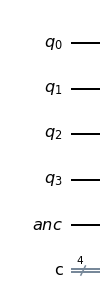

In [20]:
N = 16
n = int(np.log2(N))

qr = QuantumRegister(n,"q")
anc = QuantumRegister(1,"anc")
cr = ClassicalRegister(n,"c")

grover_circuit = QuantumCircuit(qr,anc,cr)
grover_circuit.draw(output="mpl")

### Step 1: Initialization
The first step of the algorithm is to initialize the $n$ qubits, assumed to be in the $\ket{00..0}$ state, in the uniform superposition of all possible states of the system, which we will call $\ket{s}$.
$$ \ket{s} = \frac{1}{\sqrt{N}} \sum_{x=0}^{N-1} \ket{x}$$
This can be achieved by applying an Hadamard gate to each qubit:
$$ \ket{s} = H^{\otimes n} \ket{00..0}$$

In [3]:
def initialize_s(circuit, qubits):
    """Apply a H-gate to 'qubits' in circuit"""
    for q in qubits:
        circuit.h(q)
    return circuit

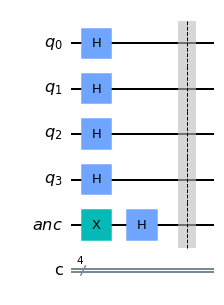

In [21]:
grover_circuit = initialize_s(grover_circuit, range(n))

# setup the ancillary qubit
grover_circuit.x(n) # |0> -> |1>
grover_circuit.h(n) # |1> -> |->

grover_circuit.barrier()
grover_circuit.draw(output="mpl")

### Step 2: Building the Oracle
The oracle is a black box that adds an overall phase to the quantum states that solve the problem. It is defined using the classical function $f(x)$ which is able to verify a solution. In particular, the overall effect is:
$$ U_w \ket{x} = (-1)^{f(x)}|x> $$
To build a gate like this, we 

In [22]:
# define a classical function f(x): this returns 1 for the solutions of the problem
# in this case, the solutions are 1010 and 1100
@classical_function
def f(x1: Int1, x2: Int1, x3: Int1, x4: Int1) -> Int1:
    return (x1 and not x2 and x3 and not x4) or (x1 and x2 and not x3 and not x4)

def oracle(nqubits):
    
    Uf = f.synth()  # turn it into a circuit
    oracle = QuantumCircuit(nqubits+1)
    oracle.compose(Uf, inplace=True)

    # why is this needed ?
    #oracle.h(nqubits)
    #oracle.x(nqubits)

    # We will return the diffuser as a gate
    U_w = oracle.to_gate()
    U_w.name = "U$_w$"
    return U_w

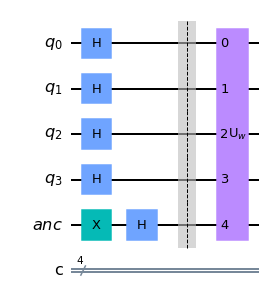

In [23]:
grover_circuit.append(oracle(n),range(n+1))
grover_circuit.draw(output="mpl")

### Step 3: Building the Grover diffuser
short explanation of what it does...
explain the general implementation used

In [16]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

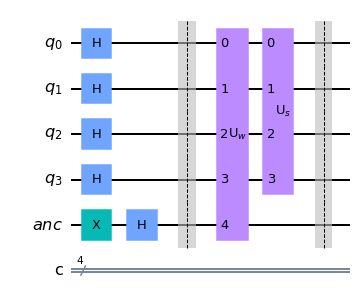

In [24]:
# Diffusion operator (U_s)
grover_circuit.append(diffuser(n),range(n))
grover_circuit.barrier()
grover_circuit.draw(output="mpl")

### Step 4: Apply and repeat

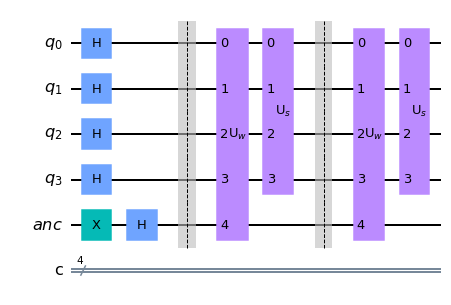

In [25]:
grover_circuit.append(oracle(n),range(n+1))
grover_circuit.append(diffuser(n),range(n))
grover_circuit.draw(output="mpl")

## Results

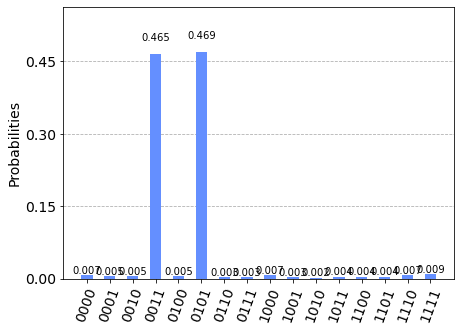

In [26]:
grover_circuit.measure(qr,cr)
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(grover_circuit, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)